In [55]:
import pandas as pd
import numpy as np
import os
import datetime
import yaml

from analysis.database import get_config

In [56]:
config = get_config()

df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
from pathlib import Path

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_05"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")

In [59]:
from typing import Literal

BASE_LABEL_FONT_SIZE = 10
BASE_TITLE_FONT_SIZE = 10
BASE_TICK_FONT_SIZE = 8


def set_figure_size(
        x_label: str,
        y_label: str,
        title_: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        y_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        title_fontsize: int = BASE_TITLE_FONT_SIZE,
        x_tick_fontsize: int = BASE_TICK_FONT_SIZE,
        y_tick_fontsize: int = BASE_TICK_FONT_SIZE,
):
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label, fontsize=y_label_fontsize)
    plt.title(title_, fontsize=title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha, fontsize=x_tick_fontsize)
    plt.yticks(fontsize=y_tick_fontsize)
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

# Number of Cases Per Variant

In [60]:
# only consider CPVT patients
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]

NUM_TOP_VARIANTS = 20

num_cases_per_variant = pd.DataFrame(
    df_cpvt["p_hgvs_aa1"].value_counts()).reset_index().sort_values(
    by=["count", "p_hgvs_aa1"], ascending=[False, True]
).head(NUM_TOP_VARIANTS)
num_cases_per_variant = num_cases_per_variant.rename(
    columns={"p_hgvs_aa1": "Variant", "count": "Number of Patients"},
)
num_cases_per_variant

,Variant,Number of Patients
0,G357S,99
1,R420Q,52
2,R420W,27
3,G2337V,23
4,G3946S,20
7,E1724K,17
5,M3978I,17
6,R4959Q,17
8,N57_G91del,16
9,P2328S,16


In [61]:
num_cases_per_variant.to_csv(
    figures_dir / "top_variants_by_num_cpvt_patients.csv"
)

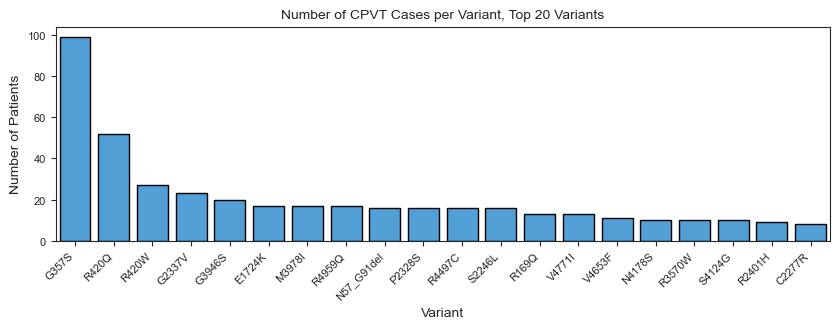

In [62]:
FIG_2_SIZE = (8.5, 3.4)

plt.figure(figsize=FIG_2_SIZE)
sns.barplot(
    data=num_cases_per_variant,
    x="Variant",
    y="Number of Patients",
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
)
# plt.title("Number of CPVT1 Cases per Variant")
# plt.xticks(rotation=45, ha="right")  # Rotate labels by 45 degrees
# plt.tight_layout()  # Adjust layout to make room for the rotated labels

set_figure_size(
    "Variant",
    "Number of Patients",
    "Number of CPVT Cases per Variant, Top 20 Variants",
    x_tick_rotation=45,
    x_tick_ha="right",
)

save_current_plot("num_cases_per_variant")

plt.show()

## Variants Per Exon

Number of unique variants per exon

In [54]:
def get_variants_per_exon(df_input: pd.DataFrame):
    # drop variants without cdna information
    unique_by_variant = df_input.dropna(subset=["c_hgvs_string"])

    unique_by_variant = unique_by_variant.drop_duplicates(
        subset=["c_hgvs_string"]
    )

    # only missense variants
    unique_by_variant = unique_by_variant[
        unique_by_variant["protein_change_type"] == "Substitution"]
    # group by
    unique_by_variant = unique_by_variant.groupby(
        "exon_start"
    ).agg({
        "c_hgvs_string": "count"
    })

    unique_by_variant = unique_by_variant.reset_index()
    unique_by_variant.columns = ["exon", "num_uq_variants"]
    unique_by_variant["exon"] = unique_by_variant["exon"].astype(int)
    unique_by_variant = unique_by_variant.sort_values(by="num_uq_variants",
                                                      ascending=False)

    return unique_by_variant


variant_per_exon = get_variants_per_exon(df_cpvt)

# save to csv
variant_per_exon.to_csv(
    figures_dir / "num_variants_per_exon.csv", index=False
)
variant_per_exon.head()

,exon,num_uq_variants
43,90,43
24,47,12
4,8,10
6,14,9
47,94,8


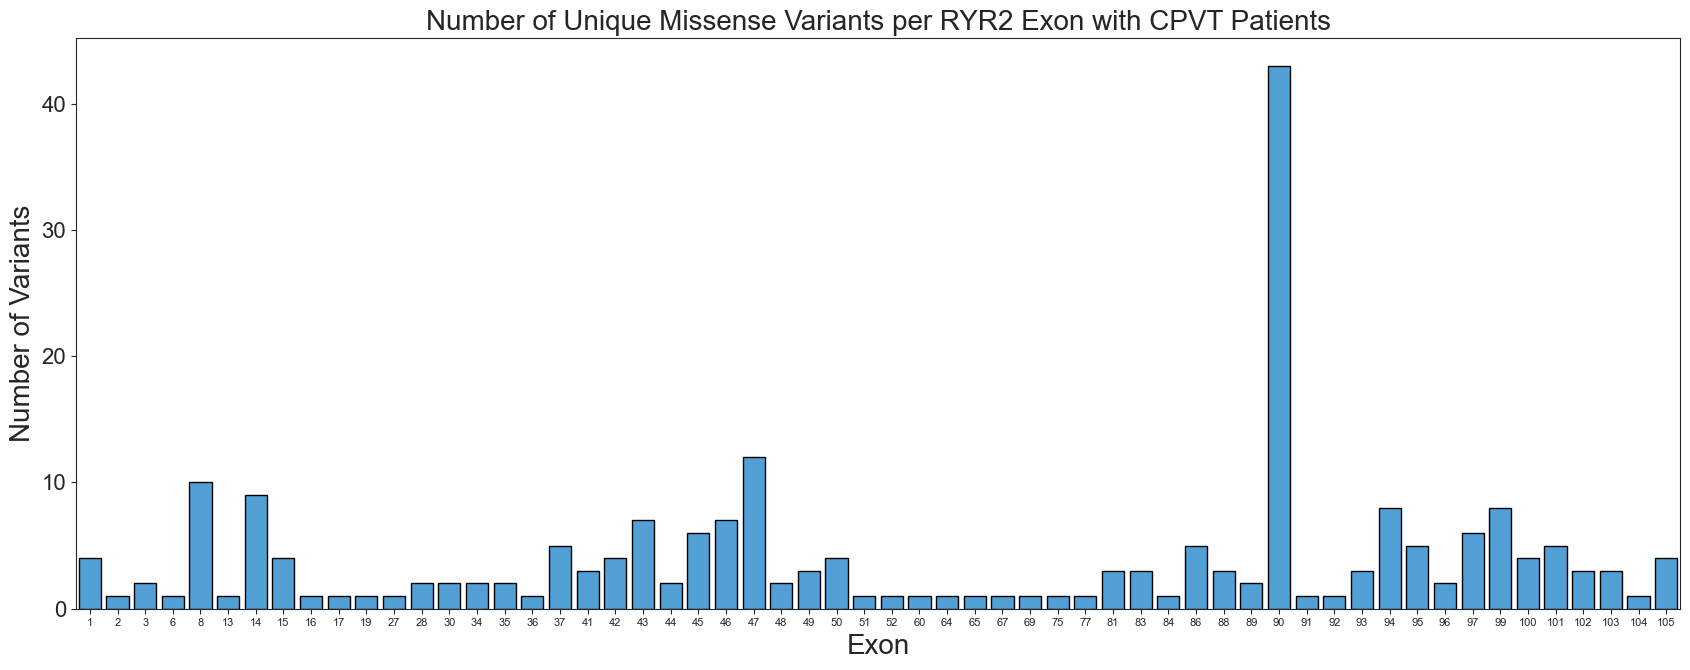

In [49]:
plt.figure(figsize=(
    FIG_2_SIZE[0] * 2, FIG_2_SIZE[1] * 2))  # Double the width and height

# y exons with more than 0 variants
plt_vars = variant_per_exon[variant_per_exon["num_uq_variants"] > 0]

sns.barplot(
    data=variant_per_exon,
    x="exon",
    y="num_uq_variants",
    # palette="pastel",
    # hue='hue',
    color=sns.color_palette("husl", 9)[6],
    legend=False,
    edgecolor="black",  # Specify the color of the border
    order=plt_vars["exon"].sort_values(),
)

set_figure_size(
    "Exon",
    "Number of Variants",
    "Number of Unique Missense Variants per RYR2 Exon with CPVT Patients",
    # double the font size
    x_label_fontsize=20,
    y_label_fontsize=20,
    title_fontsize=20,
    y_tick_fontsize=16,
)

save_current_plot("num_variants_per_exon")

plt.show()

In [50]:
# print number of exons
len(variant_per_exon)

58

## Frequency

In [65]:
cases_per_variant_freq = pd.DataFrame(
    df_cpvt["p_hgvs_string"].value_counts()).reset_index().sort_values(
    by=["count", "p_hgvs_string"], ascending=[False, True]
)["count"].value_counts()

cases_per_variant_freq.head()

count
1    142
2     44
3     24
4     19
5      9
Name: count, dtype: int64

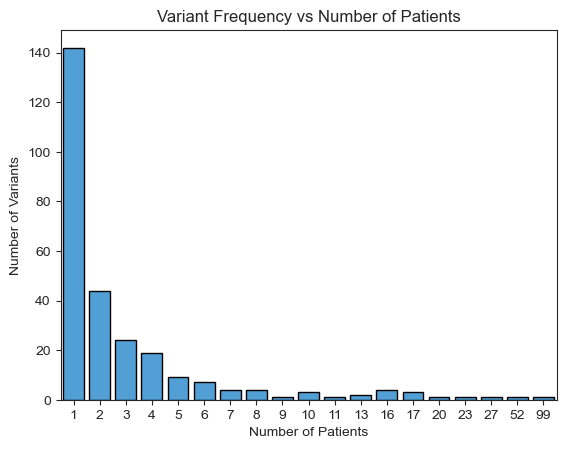

In [66]:
sns.barplot(cases_per_variant_freq,
            color=sns.color_palette("husl", 9)[6],
            legend=False,
            edgecolor="black",  # Specify the color of the border)
            )
plt.title("Variant Frequency vs Number of Patients")
plt.xlabel("Number of Patients")
plt.ylabel("Number of Variants")
plt.savefig(
    os.path.join(figures_dir, "variant_freq_vs_num_patients.png"), dpi=300)
plt.show()